In [1]:
# All Required Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
from PIL import Image

In [2]:
# Function to get the online images
def load_image(name, no_alpha=True):
    url = f'https://cloud.dfki.de/owncloud/index.php/s/THLirfoB6SYTetn/download?path=&files={name}'
    image = np.asarray(Image.open(requests.get(url, stream=True).raw))
    if no_alpha and len(image) > 2 and image.shape[2] == 4:
        image = image[:,:,:3]
    return image[:,:,::-1].copy()

# Function to resize the image
def resize(image, scale):
    return cv2.resize(image, (int(image.shape[1]*scale), int(image.shape[0]*scale)))

# Function to print the image 
def show(*images, titles=None, figsize=None, **kwargs):
    ROWS, COLS = 1, len(images)
    if figsize is not None:
        plt.figure(figsize=(18,6))
    for i, img in enumerate(images):
        plt.subplot(ROWS, COLS, i+1)
        if titles is not None:
            plt.title(titles[i])
        if len(img.shape) == 3:
            plt.imshow(img[:,:,::-1], **kwargs)
        else:
            plt.imshow(img, **kwargs)
    plt.show()

# Function to convert RGB image into Gray Scale
def gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Function to filter the image
def conv(image, kernel):
    return cv2.filter2D(src=image, ddepth=-1, kernel=kernel)

# Function to apply Gaussian Blur
def gaussian_blur(image, size):
    return cv2.GaussianBlur(image, (size, size), 0)

# Function to visualize corners
def visualize_corners(I, R, threshold=0.48):
    I = I.copy()
    loc = np.where(R >= threshold)
    for pt in zip(*loc[::-1]):
        cv2.circle(I, pt, 3, (0, 0, 255), -1)
    return I


<p style="page-break-after:always;"></p>

# Task: Corner Detection
---

In this task you will implement Harris corner detection from scratch.

<div style="background-color: #ffa252; color: #ffffff; width: 100%; padding: 0.3em; font-size:1.1em; font-weight: bold;">Harris Corner Detection</div>
<div style="background-color: #ffecdc; width: 100%; padding-top: 0.5em; padding-bottom: 0.3em">
   
1. Compute derivatives (Sobel)
2. Compute $H$ matrix
3. Compute $R$ matrix: $R = \det(H) - k \cdot \text{tr}(H)^2$.

</div>

**TASK**: Apply sobel filter.
* Apply the sobel filter in X and Y direction on the image.

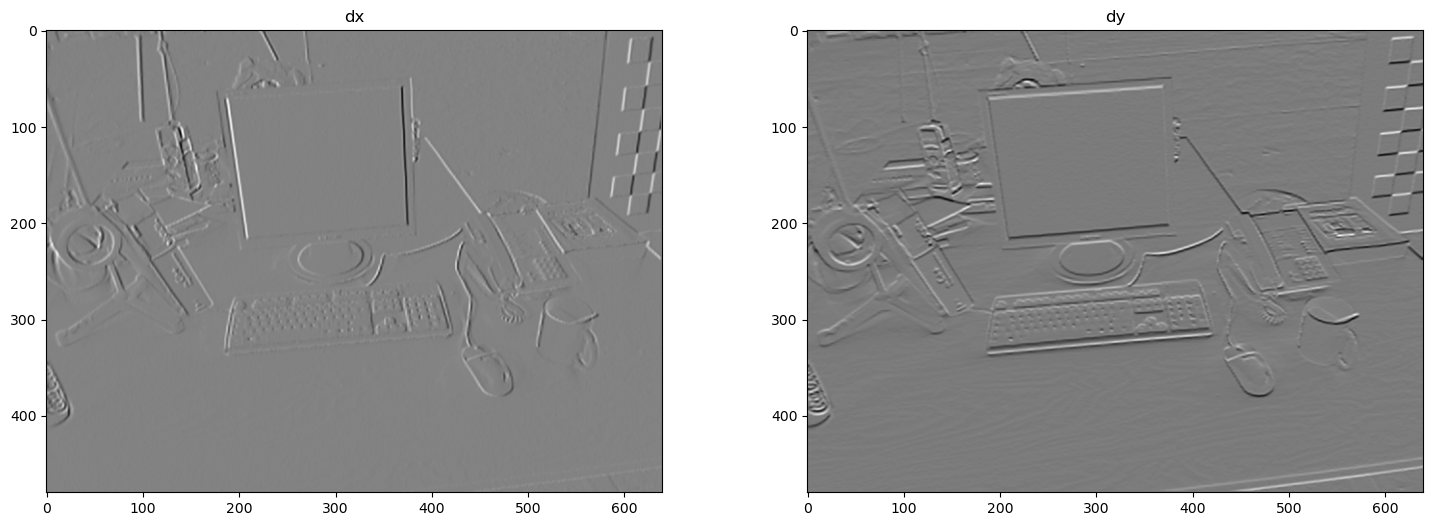

In [3]:
I = load_image("img1.png")
I_gray = gray(I) / 255.0

# Sobel Filter in X & Y Directions
SOBEL_X = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=np.float32)              
SOBEL_Y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float32)

def apply_sobel(I_gray):
    # TODO
    # Applying convolution on input image in x and y direction using respective sobel filters
    dx = conv(I_gray,SOBEL_X)  
    dy = conv(I_gray,SOBEL_Y)  
    return dx, dy

sobel = apply_sobel(I_gray)
show(
    *sobel,
    titles=["dx", "dy"],
    figsize=(16,4),
    cmap="gray"
)

**TASK**: Compute H matrix
* Compute the components of the h matrix.
    1. Compute $d_x^2$, $d_y^2$, $d_x d_y$.
    2. Weight by Gaussian $\rightarrow$ apply Gaussian blur to each of them.Using a kernel size of 5 for Gaussian blur. (I am using this kernel size you may use something else as well.)

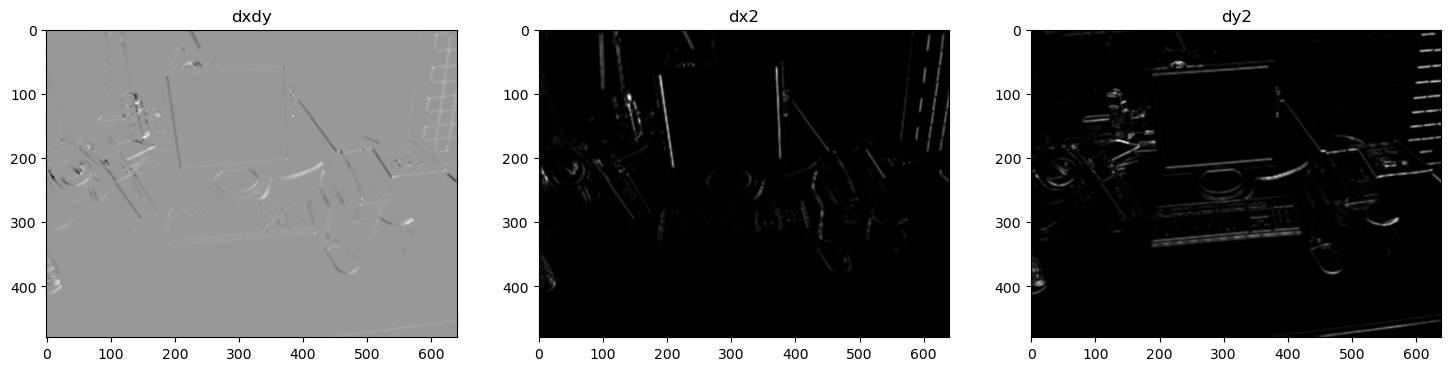

In [4]:
def compute_components_of_H(dx, dy):
    # TODO
    # Computing the components of H matrix: namely dx2,dy2 and dxdy
    dx2 = gaussian_blur(np.square(dx),5)  # make it "compile"
    dy2 = gaussian_blur(np.square(dy),5)  # make it "compile"
    dxdy = gaussian_blur(dx*dy,5)  # make it "compile"
   
    return dxdy, dx2, dy2

H = compute_components_of_H(*sobel)
show(
    *H,
    titles=["dxdy", "dx2", "dy2"],
    figsize=(16,4),
    cmap="gray"
)

**TASK**: Compute R matrix.
1. Compute the determinant: $\det(H) = d_x^2 d_y^2 - (d_x d_y)^2$
2. Compute trace: $\text{tr}(H) = d_x^2 + d_y^2$
3. Compute R matrix: $R = \det(H) - k \cdot \text{tr}(H)^2$.

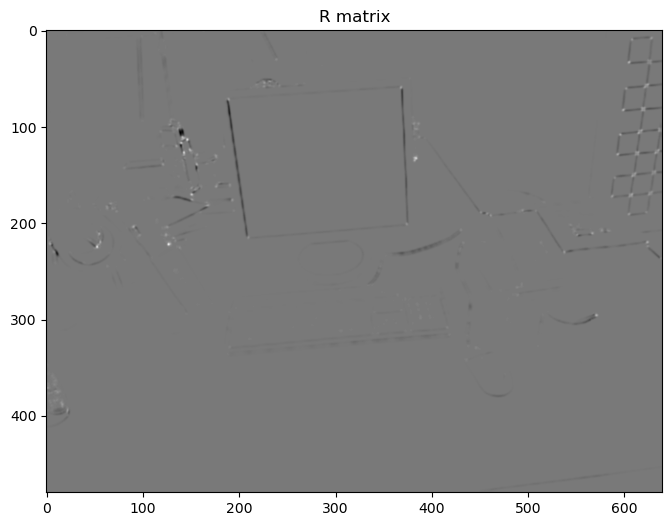

In [5]:
# Function for performing multiplication between each element of 2 matrices
def elementwise_multiplication(image_patch,kernel,image_patch_mean,kernel_mean):
    buffer=np.zeros_like(image_patch)                               # Creating a output matrix of the same size as the input matrix but with 0 value
    # Loop to perform the elementwise matrix multiplication
    for i in range (image_patch.shape[0]):
        for j in range (image_patch.shape[1]):
            buffer[i,j]=(image_patch[i,j]-image_patch_mean)*(kernel[i,j]-kernel_mean)
            
    return buffer 

def compute_R(dxdy, dx2, dy2, k=0.06):
    # TODO
    detH=elementwise_multiplication(dx2,dy2,0,0)-np.square(dxdy)    # Calculating the determinant of H                     
    trH=dx2+dy2                                                     # Calculating the Trace of H
    R = detH-k*np.square(trH)                                       # Calculating the value of R
    R=(R-np.min(R))/(np.max(R)-np.min(R))                           # Normalizing R
    
    return R

R = compute_R(*H)
show(
    R,
    titles=["R matrix"],
    figsize=(16,4),
    cmap="gray"
)

**TASK**: Since we have defined every step. Now we combine all of them into 1.
1. Apply Sobel
2. Compute H
3. Compute R

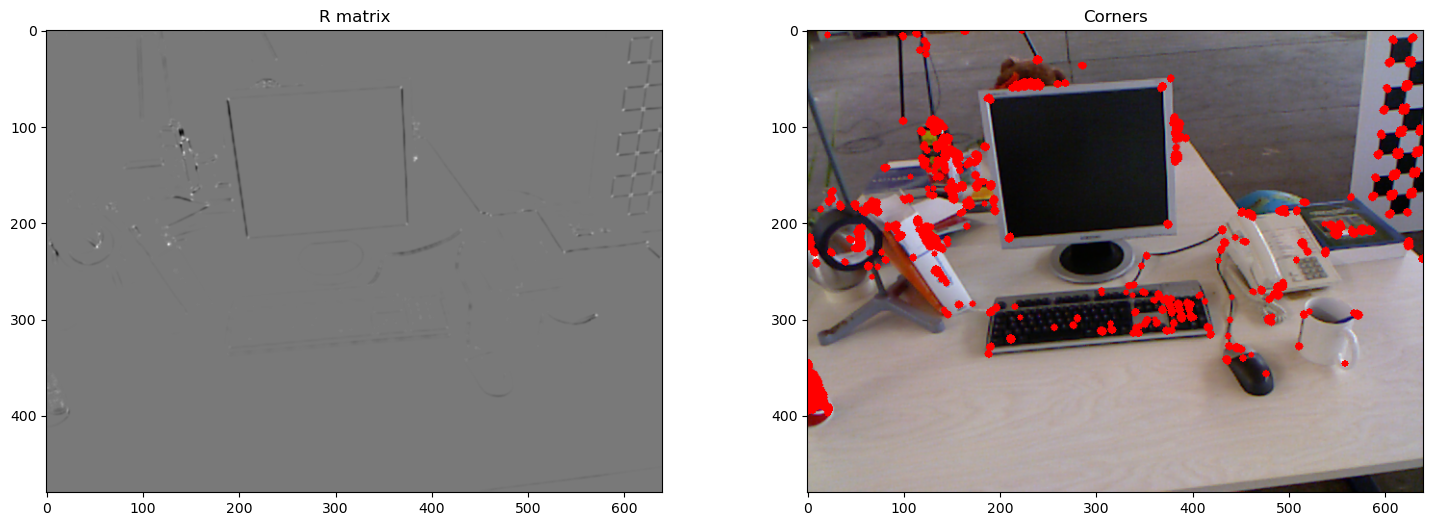

In [6]:
def harris(I_gray, k=0.06):
    # TODO
    
    # Compiling all the above defined functions
    dx,dy=apply_sobel(I_gray)
    dxdy,dx2,dy2=compute_components_of_H(dx,dy)
    R = compute_R(dxdy,dx2,dy2,k) # make it "compile"
    return R

I = load_image("img1.png")
I_gray = gray(I) / 255.0
R = harris(I_gray)
show(
    R, visualize_corners(I, R),
    titles=["R matrix", "Corners"],
    figsize=(16,4),
    cmap="gray"
)